# 6.1 RNN의 문제점

6.1.3 기울기 소실과 기울기 폭발의 원인

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # 미니배치(N개)의 평균 L2 Norm
    norm_list.append(norm)

In [62]:
np.random.randn(H, H), np.sqrt(np.sum((np.random.randn(H, H))**2))

(array([[-0.52297163, -0.06357308, -0.24977211],
        [ 0.48579018,  0.48573721,  0.25789698],
        [ 1.34407129, -0.15851092, -1.05080794]]),
 3.4748373028244255)

In [2]:
norm_list

[2.4684068094579303,
 3.335704974161037,
 4.783279375373183,
 6.2795873320876145,
 8.080776465019055,
 10.25116303229294,
 12.9360635066099,
 16.276861327786712,
 20.454829618345983,
 25.688972842084684,
 32.25315718048336,
 40.48895641683869,
 50.824407307019094,
 63.79612654485427,
 80.07737014308985,
 100.51298922051251,
 126.16331847536827,
 158.3592064825883,
 198.77107967611957,
 249.495615421267]

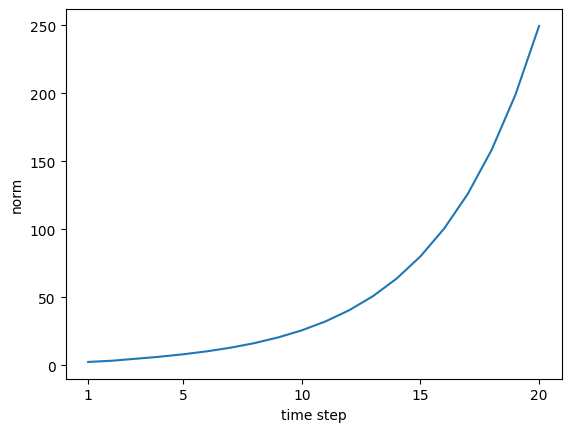

In [4]:
# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()


기울기 폭발

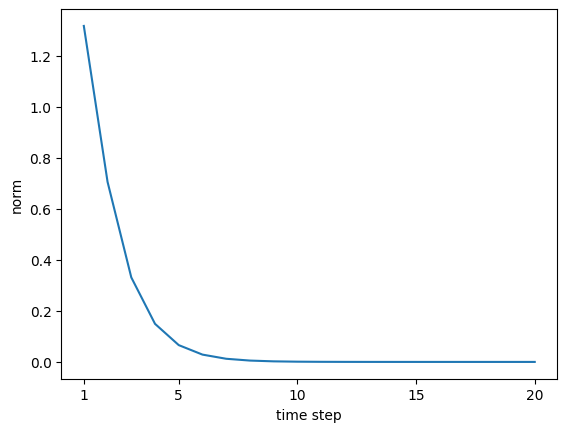

In [147]:
N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
# np.random.seed(3)
Wh = np.random.randn(H, H)

# Wh = np.random.randn(H, H)       # 변경 전
Wh = np.random.randn(H, H) * 0.5 # 변경 후

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # 미니배치(N개)의 평균 L2 Norm
    norm_list.append(norm)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

6.1.4 기울기 폭발 대책

In [150]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0 # threshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.75996587 4.4591411  6.71570248 4.60368504 7.80003222 1.13444084
 5.08157429 8.7148954  9.27529276]
after: [1.34437266 0.88680143 1.33556988 0.91554727 1.55121347 0.22560931
 1.0105864  1.73315478 1.84460251]


6.4 LSTM을 사용한 언어 모델

In [3]:
import numpy as np
from time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs): # 7장에서 수행하는 문장 생성에 사용
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)

    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.06
| 에폭 1 |  반복 21 / 1327 | 시간 2[s] | 퍼플렉서티 2861.74
| 에폭 1 |  반복 41 / 1327 | 시간 5[s] | 퍼플렉서티 1212.60
| 에폭 1 |  반복 61 / 1327 | 시간 8[s] | 퍼플렉서티 954.86
| 에폭 1 |  반복 81 / 1327 | 시간 11[s] | 퍼플렉서티 788.96
| 에폭 1 |  반복 101 / 1327 | 시간 14[s] | 퍼플렉서티 632.66
| 에폭 1 |  반복 121 / 1327 | 시간 17[s] | 퍼플렉서티 655.90
| 에폭 1 |  반복 141 / 1327 | 시간 20[s] | 퍼플렉서티 604.24
| 에폭 1 |  반복 161 / 1327 | 시간 23[s] | 퍼플렉서티 568.62
| 에폭 1 |  반복 181 / 1327 | 시간 26[s] | 퍼플렉서티 583.63
| 에폭 1 |  반복 201 / 1327 | 시간 29[s] | 퍼플렉서티 504.59
| 에폭 1 |  반복 221 / 1327 | 시간 32[s] | 퍼플렉서티 486.32
| 에폭 1 |  반복 241 / 1327 | 시간 35[s] | 퍼플렉서티 443.97
| 에폭 1 |  반복 261 / 1327 | 시간 38[s] | 퍼플렉서티 460.86
| 에폭 1 |  반복 281 / 1327 | 시간 41[s] | 퍼플렉서티 456.58
| 에폭 1 |  반복 301 / 1327 | 시간 43[s] | 퍼플렉서티 382.26
| 에폭 1 |  반복 321 / 1327 | 시간 46[s] | 퍼플렉서티 350.90
| 에폭 1 |  반복 341 / 1327 | 시간 49[s] | 퍼플렉서티 394.87
| 에폭 1 |  반복 361 / 1327 | 시간 52[s] | 퍼플렉서티 407.63
| 에폭 1 |  반복 381 / 1327 | 시간 55[s] | 퍼플렉서티 326.87
| 에폭 1

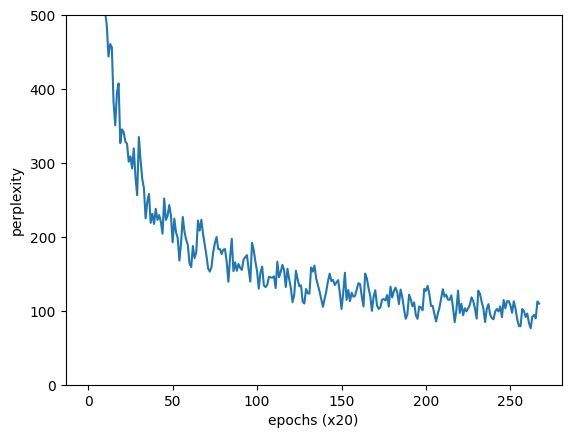

퍼플렉서티 평가 중 ...


NameError: name 'sys' is not defined

In [4]:
import numpy as np
from optimizer import SGD
from trainer import RnnlmTrainer
from utils import eval_perplexity
from data import ptb

# 하이퍼파라미터 설정
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()